In [1]:
print('Hello project!')

Hello project!


In [51]:
! pip install pdf2image pillow opencv-python matplotlib tqdm scikit-learn pandas seaborn gradio streamlit


  Using cached streamlit-1.48.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached cachetools-6.1.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached protobuf-6.31.1-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached pyarrow-21.0.0-cp312-cp312-win_amd64.whl.metadata (3.4 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached watchdog-6.0.0-py3-none-win_amd64.whl.metadata (44 kB)
  Using cached gitpython-3.1.45-py3-none-any.whl.metadata (13 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached jsonschema-4.25.0-py3-none-any.whl.metadata (7.7 kB)
  Using cached narwhals-2.0.1-py3-none-any.whl.metadata (11 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.2-py3-none-any.whl.metadata (4.3 kB


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

Looking in indexes: https://download.pytorch.org/whl/cu128



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# =======================
# 🔁 General Utilities
# =======================
import os
import random
from pathlib import Path
from tqdm import tqdm
import shutil

# =======================
# 📄 PDF Processing
# =======================
from pdf2image import convert_from_path

# =======================
# 🖼️ Image Processing
# =======================
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# =======================
# 📊 Data Handling
# =======================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn

# =======================
# 🔥 PyTorch Core
# =======================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# =======================
# 🧠 PyTorch Vision
# =======================
from torchvision import models, transforms, datasets

# =======================
# 📈 Evaluation
# =======================
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =======================
# 💻 Device Setup
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


# 📓 Phase 1 – Dataset Preparation (Jupyter Notebook Cells)


In [2]:
# Paths
PDF_PATH = "scannedbanglaPDF.pdf"
PAGE_IMAGE_DIR = "data/pages"
SNIPPET_DIR = "data/snippets"
CROP_WIDTH = 1000
CROP_HEIGHT = 750
CROPS_PER_PAGE = 10

# Create folders
os.makedirs(PAGE_IMAGE_DIR, exist_ok=True)
os.makedirs(SNIPPET_DIR, exist_ok=True)


In [3]:
# Convert PDF to images
pages = convert_from_path(PDF_PATH, dpi=300)

# Save images
for i, page in enumerate(pages):
    page_path = os.path.join(PAGE_IMAGE_DIR, f"page_{i:04}.png")
    page.save(page_path, "PNG")
    print(f"Saved: {page_path}")


Saved: data/pages\page_0000.png
Saved: data/pages\page_0001.png
Saved: data/pages\page_0002.png
Saved: data/pages\page_0003.png
Saved: data/pages\page_0004.png
Saved: data/pages\page_0005.png
Saved: data/pages\page_0006.png
Saved: data/pages\page_0007.png
Saved: data/pages\page_0008.png
Saved: data/pages\page_0009.png
Saved: data/pages\page_0010.png


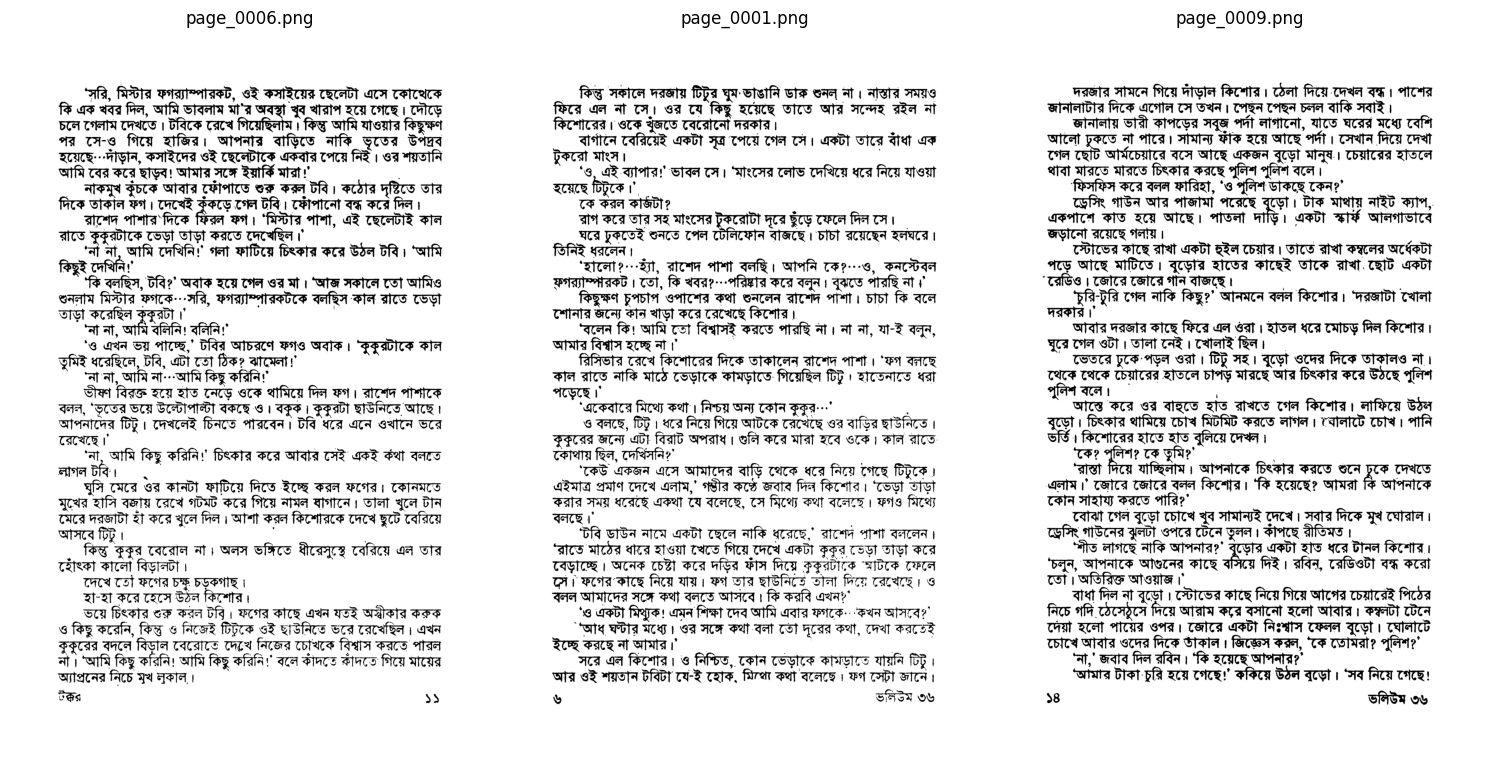

In [4]:
# Parameters
NUM_PAGES_TO_SHOW = 3  # You can change this number

# Randomly select page images
selected_pages = random.sample(list(Path(PAGE_IMAGE_DIR).glob("*.png")), NUM_PAGES_TO_SHOW)

# Plotting
plt.figure(figsize=(15, NUM_PAGES_TO_SHOW * 5))

for i, page_path in enumerate(selected_pages):
    image = Image.open(page_path)
    
    plt.subplot(1, NUM_PAGES_TO_SHOW, i + 1)
    plt.imshow(image)
    plt.title(f"{page_path.name}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [5]:
def crop_snippets_from_page(page_path, output_dir, crop_width, crop_height, num_crops=10):
    image = Image.open(page_path)
    width, height = image.size
    base_name = Path(page_path).stem

    os.makedirs(output_dir, exist_ok=True)
    
    for i in range(num_crops):
        # Ensure crops stay inside image bounds
        if width <= crop_width or height <= crop_height:
            continue  # skip small images

        left = random.randint(0, width - crop_width)
        top = random.randint(0, height - crop_height)
        right = left + crop_width
        bottom = top + crop_height

        crop = image.crop((left, top, right, bottom))
        crop.save(os.path.join(output_dir, f"{base_name}_crop_{i:02}.png"))

# Apply cropping to all page images
page_images = sorted(Path(PAGE_IMAGE_DIR).glob("*.png"))

for page_path in tqdm(page_images, desc="Cropping snippets"):
    page_id = page_path.stem
    page_snippet_dir = os.path.join(SNIPPET_DIR, page_id)
    crop_snippets_from_page(page_path, page_snippet_dir, CROP_WIDTH, CROP_HEIGHT, CROPS_PER_PAGE)


Cropping snippets:   0%|          | 0/11 [00:00<?, ?it/s]

Cropping snippets: 100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


In [6]:
from collections import defaultdict

# Count number of crops per page
snippet_counts = defaultdict(int)

for page_folder in Path(SNIPPET_DIR).glob("page_*"):
    if page_folder.is_dir():
        num_snippets = len(list(page_folder.glob("*.png")))
        snippet_counts[page_folder.name] = num_snippets

# Print stats
for page, count in snippet_counts.items():
    print(f"{page}: {count} snippets")


page_0000: 10 snippets
page_0001: 10 snippets
page_0002: 10 snippets
page_0003: 10 snippets
page_0004: 10 snippets
page_0005: 10 snippets
page_0006: 10 snippets
page_0007: 10 snippets
page_0008: 10 snippets
page_0009: 10 snippets
page_0010: 10 snippets


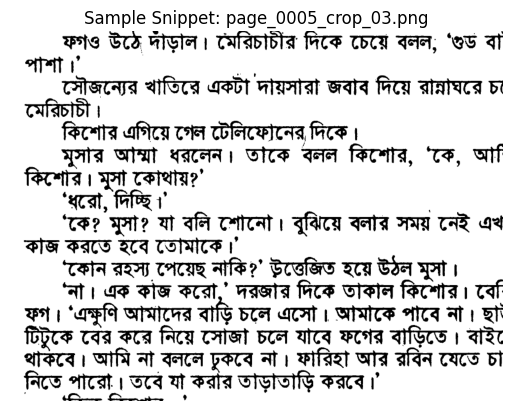

In [7]:
# Display a random snippet for verification
random_page = random.choice(list(Path(SNIPPET_DIR).glob("page_*")))
random_snippet = random.choice(list(random_page.glob("*.png")))

image = Image.open(random_snippet)
plt.imshow(image)
plt.title(f"Sample Snippet: {random_snippet.name}")
plt.axis("off")
plt.show()


In [8]:
from collections import defaultdict
import pandas as pd

# Summary dictionary
summary = {
    "Total PDF Pages": len(list(Path(PAGE_IMAGE_DIR).glob("*.png"))),
    "Crop Width": CROP_WIDTH,
    "Crop Height": CROP_HEIGHT,
    "Crops Per Page": CROPS_PER_PAGE,
    "Total Crops": 0,
    "Min Page Size (WxH)": None,
    "Max Page Size (WxH)": None,
    "Avg Page Size (WxH)": None
}

# Compute total crops and page size stats
widths, heights = [], []
total_crops = 0

for page_path in Path(PAGE_IMAGE_DIR).glob("*.png"):
    image = Image.open(page_path)
    widths.append(image.width)
    heights.append(image.height)

    page_id = page_path.stem
    snippet_folder = Path(SNIPPET_DIR) / page_id
    if snippet_folder.exists():
        total_crops += len(list(snippet_folder.glob("*.png")))

# Add to summary
summary["Total Crops"] = total_crops
summary["Min Page Size (WxH)"] = f"{min(widths)}x{min(heights)}"
summary["Max Page Size (WxH)"] = f"{max(widths)}x{max(heights)}"
summary["Avg Page Size (WxH)"] = f"{int(np.mean(widths))}x{int(np.mean(heights))}"

# Display as a table
pd.DataFrame.from_dict(summary, orient="index", columns=["Value"])


,Value
Total PDF Pages,11
Crop Width,1000
Crop Height,750
Crops Per Page,10
Total Crops,110
Min Page Size (WxH),1401x2117
Max Page Size (WxH),1401x2117
Avg Page Size (WxH),1401x2117


# 🧠 Phase 2 – Model Design (PyTorch, Jupyter Notebook Style)


In [124]:
# Resize and normalize both snippets and pages
image_size = (224, 224)  # standard input for ResNet
image_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                         std=[0.229, 0.224, 0.225])
])


In [125]:
class SnippetPageSiameseDataset(Dataset):
    def __init__(self, snippet_dir, page_dir, transform=None):
        self.transform = transform
        self.snippet_paths = []
        self.page_paths = []
        self.page_id_to_path = {}

        for page_img in sorted(Path(page_dir).glob("*.png")):
            page_id = page_img.stem
            self.page_paths.append(page_img)
            self.page_id_to_path[page_id] = page_img

        # Build snippet list with labels
        for page_folder in sorted(Path(snippet_dir).glob("page_*")):
            if page_folder.is_dir():
                for snip_img in page_folder.glob("*.png"):
                    self.snippet_paths.append((snip_img, page_folder.name))  # (path, label)

    def __len__(self):
        return len(self.snippet_paths)

    def __getitem__(self, index):
        snippet_path, label = self.snippet_paths[index]
        snippet_img = Image.open(snippet_path).convert("RGB")

        # Positive (same page)
        pos_page_path = self.page_id_to_path[label]
        pos_img = Image.open(pos_page_path).convert("RGB")

        # Negative (random page)
        neg_label = random.choice([l for l in self.page_id_to_path if l != label])
        neg_page_path = self.page_id_to_path[neg_label]
        neg_img = Image.open(neg_page_path).convert("RGB")

        if self.transform:
            snippet_img = self.transform(snippet_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)

        return {
            'snippet': snippet_img,
            'pos_page': pos_img,
            'neg_page': neg_img,
            'label': label
        }


In [126]:
class EmbeddingCNN(nn.Module):
    def __init__(self, embedding_dim=128):
        super(EmbeddingCNN, self).__init__()
        base_model = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])  # remove classifier
        self.fc = nn.Linear(512, embedding_dim)

    def forward(self, x):
        x = self.backbone(x)  # shape: (B, 512, 1, 1)
        x = x.view(x.size(0), -1)  # flatten to (B, 512)
        x = self.fc(x)
        x = F.normalize(x, p=2, dim=1)  # L2 normalize
        return x


In [127]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # label: 1 if same, 0 if different
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = label * torch.pow(euclidean_distance, 2) + \
               (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        return torch.mean(loss)


# 📓 Phase 3 — Training Loop (Jupyter Notebook Cells)


In [128]:
# Training hyperparameters
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
MARGIN = 1.0  # for contrastive loss


In [129]:
# Recreate dataset with larger batch size
train_dataset = SnippetPageSiameseDataset(SNIPPET_DIR, PAGE_IMAGE_DIR, transform=image_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [130]:
model = EmbeddingCNN().to(device)
criterion = ContrastiveLoss(margin=MARGIN)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


c:\Users\Soleman Hossain\Documents\LipiSearch-testspace\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Soleman Hossain\Documents\LipiSearch-testspace\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [131]:
from tqdm import tqdm

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_matches = 0
    total_pairs = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch in loop:
        snippet = batch['snippet'].to(device)
        pos_page = batch['pos_page'].to(device)
        neg_page = batch['neg_page'].to(device)

        optimizer.zero_grad()

        # Forward pass
        emb_snippet = model(snippet)
        emb_pos = model(pos_page)
        emb_neg = model(neg_page)

        # Contrastive loss
        pos_labels = torch.ones(snippet.size(0)).to(device)
        neg_labels = torch.zeros(snippet.size(0)).to(device)

        loss_pos = criterion(emb_snippet, emb_pos, pos_labels)
        loss_neg = criterion(emb_snippet, emb_neg, neg_labels)
        loss = loss_pos + loss_neg

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Accuracy computation
        pos_sim = F.pairwise_distance(emb_snippet, emb_pos)
        neg_sim = F.pairwise_distance(emb_snippet, emb_neg)

        correct_matches += torch.sum(pos_sim < neg_sim).item()
        total_pairs += snippet.size(0)

        loop.set_postfix({
            "Loss": f"{running_loss / total_pairs:.4f}",
            "Acc": f"{(correct_matches / total_pairs) * 100:.2f}%"
        })

    print(f"Epoch {epoch+1} finished: Avg Loss = {running_loss/total_pairs:.4f}, Accuracy = {(correct_matches / total_pairs) * 100:.2f}%")


Epoch 1/10: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it, Loss=0.0192, Acc=64.55%]


Epoch 1 finished: Avg Loss = 0.0192, Accuracy = 64.55%


Epoch 2/10: 100%|██████████| 4/4 [00:13<00:00,  3.42s/it, Loss=0.0133, Acc=93.64%]


Epoch 2 finished: Avg Loss = 0.0133, Accuracy = 93.64%


Epoch 3/10: 100%|██████████| 4/4 [00:13<00:00,  3.38s/it, Loss=0.0104, Acc=97.27%]


Epoch 3 finished: Avg Loss = 0.0104, Accuracy = 97.27%


Epoch 4/10: 100%|██████████| 4/4 [00:13<00:00,  3.41s/it, Loss=0.0076, Acc=99.09%] 


Epoch 4 finished: Avg Loss = 0.0076, Accuracy = 99.09%


Epoch 5/10: 100%|██████████| 4/4 [00:13<00:00,  3.39s/it, Loss=0.0052, Acc=100.00%]


Epoch 5 finished: Avg Loss = 0.0052, Accuracy = 100.00%


Epoch 6/10: 100%|██████████| 4/4 [00:13<00:00,  3.41s/it, Loss=0.0039, Acc=100.00%]


Epoch 6 finished: Avg Loss = 0.0039, Accuracy = 100.00%


Epoch 7/10: 100%|██████████| 4/4 [00:13<00:00,  3.41s/it, Loss=0.0031, Acc=100.00%]


Epoch 7 finished: Avg Loss = 0.0031, Accuracy = 100.00%


Epoch 8/10: 100%|██████████| 4/4 [00:13<00:00,  3.43s/it, Loss=0.0026, Acc=100.00%]


Epoch 8 finished: Avg Loss = 0.0026, Accuracy = 100.00%


Epoch 9/10: 100%|██████████| 4/4 [00:13<00:00,  3.38s/it, Loss=0.0018, Acc=100.00%]


Epoch 9 finished: Avg Loss = 0.0018, Accuracy = 100.00%


Epoch 10/10: 100%|██████████| 4/4 [00:13<00:00,  3.41s/it, Loss=0.0016, Acc=100.00%]

Epoch 10 finished: Avg Loss = 0.0016, Accuracy = 100.00%


In [132]:
# Save the model
MODEL_PATH = "models/siamese_embedding_model.pth"
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


Model saved to models/siamese_embedding_model.pth


# 🎯 Phase 4 – Evaluation


In [133]:
model = EmbeddingCNN().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print("Model loaded.")


Model loaded.


In [134]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Prepare mapping
page_paths = sorted(list(Path(PAGE_IMAGE_DIR).glob("*.png")))
page_ids = [p.stem for p in page_paths]
page_id_to_idx = {pid: idx for idx, pid in enumerate(page_ids)}
num_classes = len(page_ids)

# Containers
true_labels = []
pred_labels = []
similarity_matrix = []

print("Evaluating all snippets against all pages...")
for page_folder in tqdm(sorted(Path(SNIPPET_DIR).glob("page_*"))):
    if not page_folder.is_dir():
        continue

    true_class = page_id_to_idx[page_folder.name]

    for snippet_path in sorted(page_folder.glob("*.png")):
        snippet = Image.open(snippet_path).convert("RGB")
        snippet = image_transform(snippet).unsqueeze(0).to(device)

        with torch.no_grad():
            snippet_embedding = model(snippet)

        sims = []
        for page_path in page_paths:
            page = Image.open(page_path).convert("RGB")
            page = image_transform(page).unsqueeze(0).to(device)
            with torch.no_grad():
                page_embedding = model(page)
                sim = F.cosine_similarity(snippet_embedding, page_embedding).item()
            sims.append(sim)

        similarity_matrix.append(sims)
        true_labels.append(true_class)
        pred_labels.append(np.argmax(sims))

similarity_matrix = np.array(similarity_matrix)
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)


Evaluating all snippets against all pages...


100%|██████████| 11/11 [01:22<00:00,  7.49s/it]


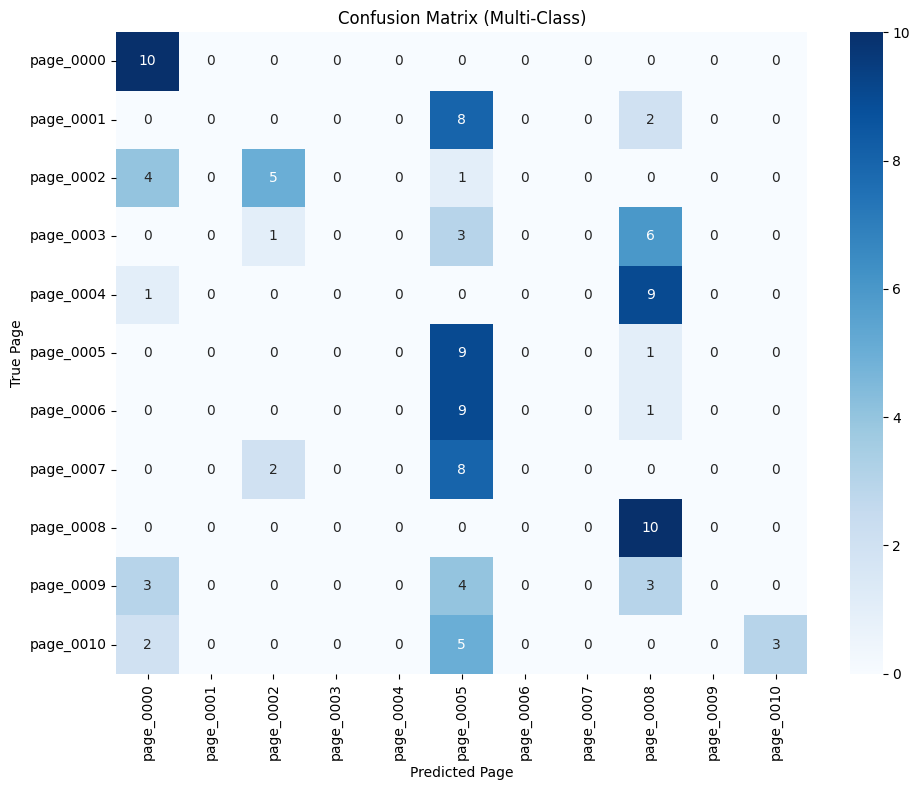

In [135]:
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=page_ids, yticklabels=page_ids)
plt.title("Confusion Matrix (Multi-Class)")
plt.xlabel("Predicted Page")
plt.ylabel("True Page")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


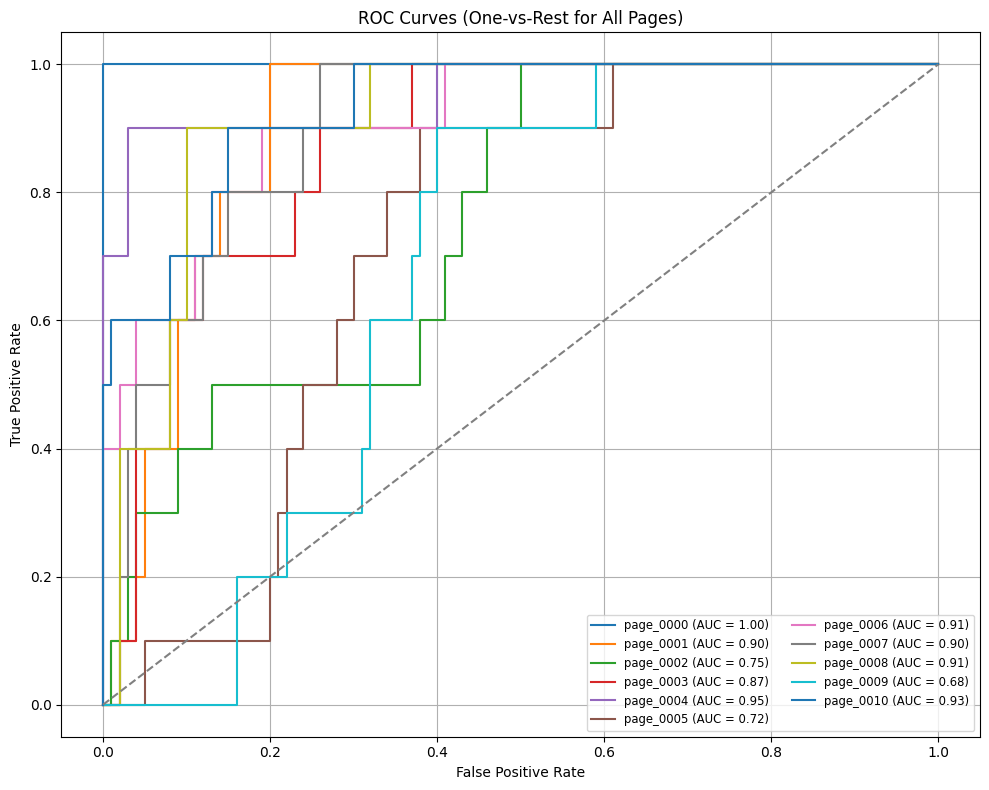

In [136]:
y_true_bin = label_binarize(true_labels, classes=list(range(num_classes)))
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], similarity_matrix[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], similarity_matrix[:, i])
    plt.plot(fpr[i], tpr[i], label=f"{page_ids[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest for All Pages)")
plt.legend(loc="lower right", fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


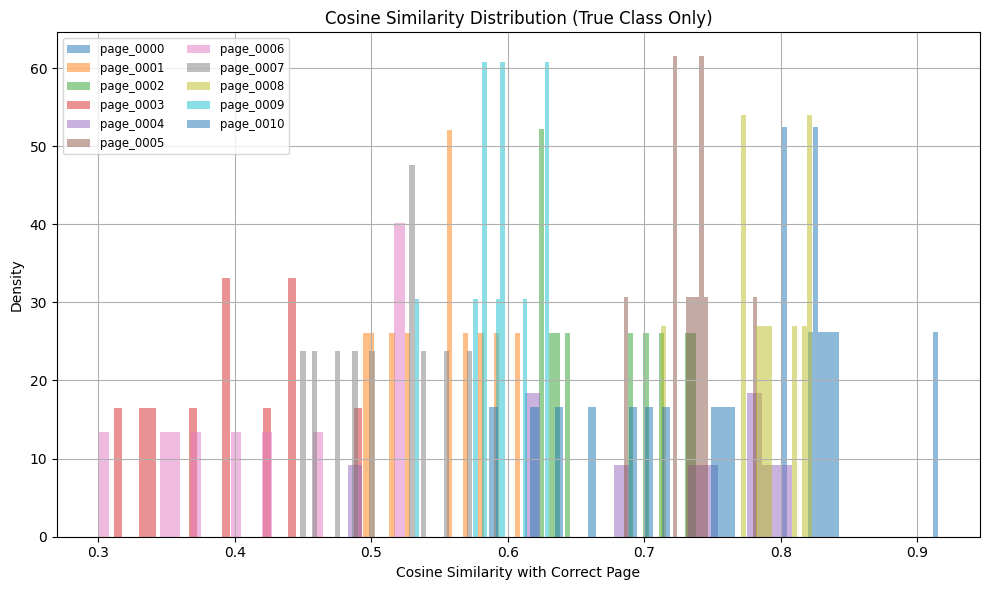

In [137]:
plt.figure(figsize=(10, 6))

for i in range(num_classes):
    class_similarities = similarity_matrix[true_labels == i, i]  # true positives
    plt.hist(class_similarities, bins=30, alpha=0.5, label=f"{page_ids[i]}", density=True)

plt.title("Cosine Similarity Distribution (True Class Only)")
plt.xlabel("Cosine Similarity with Correct Page")
plt.ylabel("Density")
plt.legend(fontsize='small', loc='upper left', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [138]:
acc = accuracy_score(true_labels, pred_labels)
prec = precision_score(true_labels, pred_labels, average='macro')
rec = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")


Accuracy:  0.3364
Precision: 0.2390
Recall:    0.3364
F1 Score:  0.2251


c:\Users\Soleman Hossain\Documents\LipiSearch-testspace\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


# 🚀 Phase 5: Matching Test Phase (Inference & Retrieval)


In [139]:
page_image_paths = sorted(Path(PAGE_IMAGE_DIR).glob("*.png"))

page_embeddings = {}
model.eval()

with torch.no_grad():
    for p_path in tqdm(page_image_paths, desc="Computing page embeddings"):
        img = Image.open(p_path).convert("RGB")
        inp = image_transform(img).unsqueeze(0).to(device)
        emb = model(inp).cpu().numpy()
        page_embeddings[p_path.stem] = emb[0]

print(f"Precomputed embeddings for {len(page_embeddings)} pages.")


Computing page embeddings: 100%|██████████| 11/11 [00:00<00:00, 14.32it/s]

Precomputed embeddings for 11 pages.


In [140]:
def manual_snippet_match(snippet_path, page_embeddings, model, top_k=3):
    """
    Given a snippet image file path, find top_k matching PDF pages.
    """
    model.eval()
    snippet_img = Image.open(snippet_path).convert("RGB")
    inp = image_transform(snippet_img).unsqueeze(0).to(device)

    with torch.no_grad():
        snippet_emb = model(inp).cpu().numpy()

    similarities = {}
    for page_id, page_emb in page_embeddings.items():
        cos_sim = np.dot(snippet_emb, page_emb.T) / (np.linalg.norm(snippet_emb) * np.linalg.norm(page_emb))
        similarities[page_id] = cos_sim[0]

    sorted_pages = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_pages[:top_k]


In [141]:
# Replace this with your own snippet image path
test_snippet_path = "data/snippets/page_0005/page_0005_crop_02.png"

top_matches = manual_snippet_match(test_snippet_path, page_embeddings, model, top_k=3)

print(f"Matching results for snippet: {test_snippet_path}")
for page_id, score in top_matches:
    print(f"Page: {page_id}, Similarity: {score:.4f}")


Matching results for snippet: data/snippets/page_0005/page_0005_crop_02.png
Page: page_0005, Similarity: 0.7317
Page: page_0008, Similarity: 0.7170
Page: page_0000, Similarity: 0.7020


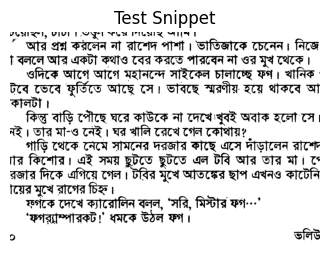

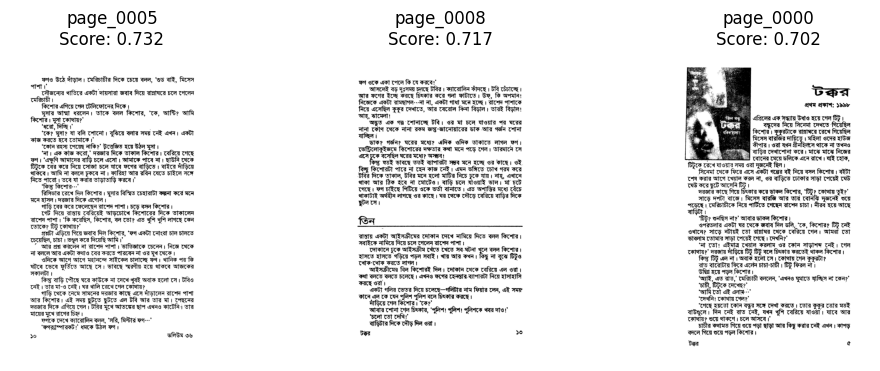

In [142]:
snippet_img = Image.open(test_snippet_path)
plt.figure(figsize=(4,4))
plt.title("Test Snippet")
plt.imshow(snippet_img)
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 4))
for i, (page_id, score) in enumerate(top_matches):
    img_path = Path(PAGE_IMAGE_DIR) / f"{page_id}.png"
    img = Image.open(img_path)
    plt.subplot(1, len(top_matches), i+1)
    plt.imshow(img)
    plt.title(f"{page_id}\nScore: {score:.3f}")
    plt.axis('off')
plt.show()
